# 1. import needed package

In [1]:
from mxnet import autograd
from mxnet import gluon
from mxnet import image
from mxnet import init
from mxnet import nd
from mxnet.gluon.model_zoo import vision as model
from mxnet.gluon import nn
from mxnet.gluon.data import vision
import numpy as np
import mxnet as mx
import sys
sys.path.insert(0, '../../utils')
from dataset import *
from netlib import *
import os
import shutil
from cifar10_utils import show_images, parse_log, show_log, update

ctx = mx.gpu(0)
arrayds_dir = '/home/hui/dataset/CIFAR10/arraydataset/'

def mkdir_if_not_exist(path):
    if not os.path.exists(os.path.join(*path)):
        os.makedirs(os.path.join(*path))

# 2. data loader, data argument

In [2]:
"""
data loader
"""
def _transform_test(data, label):
    im = data.astype('float32') / 255
    auglist = image.CreateAugmenter(data_shape=(3, 32, 32), mean=np.array([0.4914, 0.4822, 0.4465]),
                                   std=np.array([0.2023, 0.1994, 0.2010]))
    for aug in auglist:
        im = aug(im)
    im = nd.transpose(im, (2, 0, 1))
    return im, nd.array([label]).astype('float32')

def load_all_data_label(pathes):
    all_data, all_label = None, None
    for path in pathes:
        data, label = nd.load(path)
        label = label.reshape((-1,)).astype('float32')
        if all_data is None:
            all_data, all_label = data, label
        else:
            all_data = nd.concat(all_data, data, dim=0)
            all_label = nd.concat(all_label, label, dim=0)
    return all_data, all_label


def data_loader(batch_size, transform_train, transform_test=None, num_workers=0, pathes=None, arrayds=False):
    if transform_train is None:
        transform_train = _transform_train
    if transform_test is None:
        transform_test = _transform_test
        
    # flag=1 mean 3 channel image
    if pathes is None:
        train_ds = gluon.data.vision.datasets.CIFAR10(root='~/.mxnet/datasets/cifar10', train=True, transform=transform_train)
    else:
        if not arrayds:
            train_ds = MultiFolderDataset(pathes, transform=transform_train)
        else:
            train_ds = MyArrayDataset(load_all_data_label(pathes), transform=transform_train)
    test_ds = gluon.data.vision.datasets.CIFAR10(root='~/.mxnet/datasets/cifar10', train=False, transform=transform_test)

    loader = gluon.data.DataLoader
    train_data = loader(train_ds, batch_size, shuffle=True, last_batch='keep', num_workers=num_workers)
    test_data = loader(test_ds, batch_size, shuffle=False, last_batch='keep', num_workers=num_workers)
    return train_data, test_data

In [3]:
"""
data argument
"""
def transform_train_DA1(data, label):
    im = data.asnumpy()
    im = np.pad(im, ((4, 4), (4, 4), (0, 0)), mode='constant', constant_values=0)
    im = nd.array(im, dtype='float32') / 255
    auglist = image.CreateAugmenter(data_shape=(3, 32, 32), resize=0, rand_mirror=True,
                                    rand_crop=True,
                                   mean=np.array([0.4914, 0.4822, 0.4465]),
                                   std=np.array([0.2023, 0.1994, 0.2010]))
    for aug in auglist:
        im = aug(im)
    im = nd.transpose(im, (2, 0, 1)) # channel x width x height
    return im, nd.array([label]).astype('float32')


def transform_train_DA2(data, label):
    im = data.astype(np.float32) / 255
    auglist = [image.RandomSizedCropAug(size=(32, 32), min_area=0.49, ratio=(0.5, 2))]
    _aug = image.CreateAugmenter(data_shape=(3, 32, 32), resize=0, 
                                rand_crop=False, rand_resize=False, rand_mirror=True,
                                mean=np.array([0.4914, 0.4822, 0.4465]),
                                std=np.array([0.2023, 0.1994, 0.2010]),
                                brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3,
                                pca_noise=0.01, rand_gray=0, inter_method=2)
    auglist.append(image.RandomOrderAug(_aug))
    
    for aug in auglist:
        im = aug(im)
    
    im = nd.transpose(im, (2, 0, 1))
    return (im, nd.array([label]).asscalar().astype('float32'))
    

random_clip_rate = 0.3
def transform_train_DA3(data, label):
    im = data.astype(np.float32) / 255
    auglist = [image.RandomSizedCropAug(size=(32, 32), min_area=0.49, ratio=(0.5, 2))]
    _aug = image.CreateAugmenter(data_shape=(3, 32, 32), resize=0, 
                                rand_crop=False, rand_resize=False, rand_mirror=True,
#                                mean=np.array([0.4914, 0.4822, 0.4465]),
#                                std=np.array([0.2023, 0.1994, 0.2010]),
                                brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3,
                                pca_noise=0.01, rand_gray=0, inter_method=2)
    auglist.append(image.RandomOrderAug(_aug))

    for aug in auglist:
        im = aug(im)
        
    if random.random() > random_clip_rate:
        im = im.clip(0, 1)
    _aug = image.ColorNormalizeAug(mean=np.array([0.4914, 0.4822, 0.4465]),
                   std=np.array([0.2023, 0.1994, 0.2010]),)
    im = _aug(im)
    
    im = nd.transpose(im, (2, 0, 1))
    return (im, nd.array([label]).asscalar().astype('float32'))

# 3 data aurgument: mixup
1. mixup define
2. mixup visualize

## 3.1 mixup: define

In [4]:
import numpy as np
def mixup(x1, y1, x2, y2, alpha, num_class):
    y1 = nd.one_hot(y1, num_class)
    y2 = nd.one_hot(y2, num_class)
    
    lam = np.random.beta(alpha, alpha)
    x = lam * x1 + (1 - lam) * x2
    y = lam * y1 + (1 - lam) * y2
    return x, y

## 3.2 mixup: visulize

In [5]:
from mxnet import gluon
from mxnet.gluon.model_zoo import vision as model
from time import time
batch_size = 32
transform_train = _transform_test#transform_train_DA1
train_data, test_data = data_loader(batch_size, transform_train)
mixup_alpha = 1

# for x1, y1 in train_data:
#     for x2, y2 in mixup_train_data:
#         data, label = mixup(x1, y1, x2, y2, mixup_alpha, 10)
#         break
#     break

for x, y in train_data:
    l = x.shape[0] / 2
    data, label = mixup(x[:l], y[:l], x[l:2*l], y[l:2*l], mixup_alpha, 10)
    break

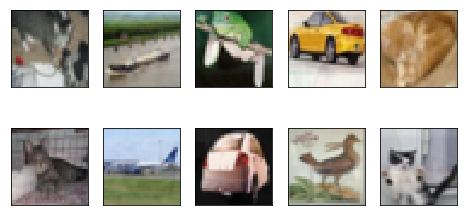

[(0, 'airplane'), (1, 'automobile'), (2, 'bird'), (3, 'cat'), (4, 'deer'), (5, 'dog'), (6, 'frog'), (7, 'horse'), (8, 'ship'), (9, 'truck')]

[[[ 0.          0.          0.          0.87480533  0.          0.          0.
    0.          0.12519467  0.        ]]

 [[ 0.          0.          0.          0.          0.          0.          0.
    0.12519467  0.87480533  0.        ]]

 [[ 0.          0.          0.          0.12519467  0.          0.
    0.87480533  0.          0.          0.        ]]

 [[ 0.          0.87480533  0.          0.          0.          0.          0.
    0.          0.          0.12519467]]

 [[ 0.          0.          0.          1.          0.          0.          0.
    0.          0.          0.        ]]

 [[ 0.          0.          0.          0.87480533  0.          0.          0.
    0.          0.          0.12519467]]

 [[ 0.87480533  0.          0.          0.          0.          0.
    0.12519467  0.          0.          0.        ]]

 [[ 0.     

In [6]:
from cifar10_utils import show_images
%matplotlib inline
mean=np.array([0.4914, 0.4822, 0.4465])
std=np.array([0.2023, 0.1994, 0.2010])
images = data[:10].transpose((0, 2, 3, 1)).asnumpy()
images = images * std + mean
images = images.transpose((0, 3, 1, 2)) * 255
show_images(images)
#show_images(data[:9], rgb_mean=mean*255, std=std*255)

print [(i, l) for i, l in enumerate(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])]
print label[:10]

## 3.3 mixup: train

In [5]:
from time import time
mixup_test = False

if mixup_test:
    net = ResNet164_v2(10)
    net.collect_params().initialize(mx.init.Xavier(), ctx=ctx, force_reinit=True)
    loss_f = gluon.loss.SoftmaxCrossEntropyLoss(sparse_label=False)

    num_epochs = 1
    learning_rate = 0.1
    weight_decay = 1e-4

    cur_time = time()
    iters = 0
    """
    data loader first time run will cost about 3x time than after run.
    """
    for x1, y1 in train_data:
        if iters % 100 == 0:
            print iters, time() - cur_time
        iters += 1
    print "cost time:", time() - cur_time
    print
    cur_time = time()

    iters = 0
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1, 'momentum': 0.9, 'wd': 1e-4})
    for x, y in train_data:
        l = x.shape[0] / 2
        data, label = mixup(x[:l], y[:l], x[l:2*l], y[l:2*l], mixup_alpha, 10)

        with autograd.record():
            output = net(data.as_in_context(ctx))
            loss = loss_f(output, label.as_in_context(ctx))
        loss.backward()
        trainer.step(data.shape[0])

        if iters % 100 == 0:
            print iters, time() - cur_time, nd.mean(loss).asscalar()
        iters += 1
    print iters, time() - cur_time

    # load data one by one batch
    # iters = 0
    # for x1, y1 in train_data:
    #     for x2, y2 in mixup_train_data:
    #         data, label = mixup(x1, y1, x2[:x1.shape[0]], y2[:y1.shape[0]], mixup_alpha, 10)
    #         break
    #     if iters % 100 == 0:
    #         print iters, time() - cur_time
    #     iters += 1
    # print "cost time:", time() - cur_time
    # print
    # cur_time = time()

    # zip will load all datas and then iterate them, too cost memory, will drop speed when memory over.
    # iters = 0
    # for (x1, y1), (x2, y2) in zip(train_data, mixup_train_data):
    #     data, label = mixup(x1, y1, x2, y2, mixup_alpha, 10)
    #     if iters % 100 == 0:
    #         print iters, time() - cur_time#, nd.mean(loss).asscalar()
    #     iters += 1
    # print time() - cur_time

# 3. data augment: back grad

## 3.1 define a simple back grad method

In [5]:
from cifar10_utils import show_images
%matplotlib inline

def SGD(data, lr):
    data[:] = data - data.grad * lr
    
def inv_normalize(data, clip=True):
    mean=np.array([0.4914, 0.4822, 0.4465])
    std=np.array([0.2023, 0.1994, 0.2010])
    images = data.transpose((0, 2, 3, 1)).asnumpy()
    images = images * std + mean
    images = images.transpose((0, 3, 1, 2)) * 255
    if clip: 
        images = images.clip(0, 255)
    return images
    
def show_data(data, clip=True):
    images = inv_normalize(data, clip)
    show_images(images)
    
class BNControl():
    """
        only support renet18 by me now.
    """
    @staticmethod
    def collect_BN(blocks):
        BN = []
        for blk in blocks:
            _type = str(blk).split('(')[0]
            if _type == 'BatchNorm':
                BN.append(blk)
            elif _type == 'Residual':
                BN.extend([blk.bn1, blk.bn2])
        return BN
    
    def __init__(self, blocks, use_batch=True):
        self.bns = BNControl.collect_BN(blocks)
        self.use_batch = use_batch
        self.data_list = []
        
    def store(self):
        if self.use_batch: # use batch data and no change running mean/std
            if len(self.data_list) == 0:
                for i, bn in enumerate(self.bns):
                    self.data_list.append(bn.params.get('running_mean').data().copy())
                    self.data_list.append(bn.params.get('running_var').data().copy())
            else:
                for i, bn in enumerate(self.bns):
                    self.data_list[2*i][:] = bn.params.get('running_mean').data()
                    self.data_list[2*i+1][:] = bn.params.get('running_var').data()
        else: # no use batch data and no change running mean/std
            for i, bn in enumerate(self.bns):
                self.data_list.append(bn._kwargs['use_global_stats'])
                bn._kwargs['use_global_stats'] = True
        
    def load(self):
        if self.use_batch:
            for i in range(len(self.bns)):
                bn, mean, std = self.bns[i], self.data_list[2*i], self.data_list[2*i+1]
                bn.params.get('running_mean').set_data(mean)
                bn.params.get('running_var').set_data(std)
        else:
            for i in range(len(self.bns)):
                bn, data = self.bns[i], self.data_list[i]
                bn._kwargs['use_global_stats'] = data
    
def generate_backgrad_data(net, data, label, max_iters=60, lr=0.1, iter_log=False, clip=True, bn_control=None):
    if bn_control is not None:
        bn_control.store()
    for iters in range(1, max_iters+1):
        with autograd.record():
            data.attach_grad()
            output = net(data.as_in_context(ctx))
            loss = -loss_f(output, label.as_in_context(ctx))
        loss.backward()
        
        if iter_log and iters % 50 == 0:
            show_data(data[:10], clip)
            print data[0, 0, :2, :10]
            print data.grad[0, 0, :2, :10]
        if iter_log and iters % 5 == 0:
            print 'iter:', iters, 'loss:', nd.mean(loss).asscalar()
        
        SGD(data, lr)
    if bn_control is not None:
        bn_control.load()
    return data, (nd.mean(loss).asscalar(),)

In [6]:
def get_soft_label(y, num_class, soft_label_th):
    y = y.reshape((-1,))
    ny = (y.one_hot(num_class) + soft_label_th / num_class)
    y = y.asnumpy()
    ny[range(y.shape[0]), y.astype('int32')] -= soft_label_th
    return nd.array(ny)

In [ ]:
ny = get_soft_label(y, 10, 0.1)
print nd.sum(ny, axis=1)

## 3.2 view result

In [10]:
net = ResNet(10)
net.load_params('../../models/resnet18_me_200e', ctx=ctx)
loss_f = gluon.loss.SoftmaxCrossEntropyLoss()
for data, label in train_data:
    data = data.as_in_context(ctx)
    label = label.as_in_context(ctx)
    break

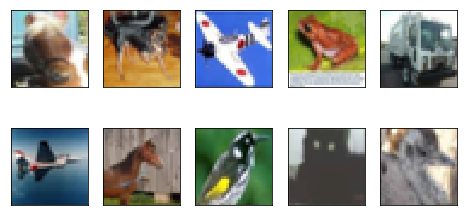

iter: 5 loss: -0.653574
iter: 10 loss: -8.564
iter: 15 loss: -20.576
iter: 20 loss: -24.9794
iter: 25 loss: -27.0003
iter: 30 loss: -28.422
iter: 35 loss: -29.5991
iter: 40 loss: -30.2958
iter: 45 loss: -30.7695


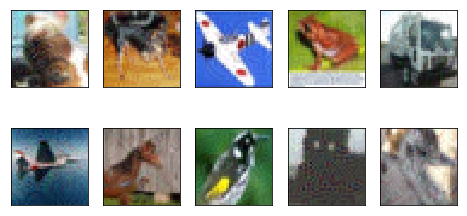


[[ 0.84831941  0.43412015  0.055559    0.40172759  0.22163963  0.3280842
   0.43882918  0.57305658  0.55760622  0.71607369]
 [ 0.6209408   0.33316466  0.2598415   0.10612462  0.08188817  0.53343666
   0.47439697  0.40720972  0.66907173  1.33878851]]
<NDArray 2x10 @gpu(0)>

[[ 0.00107157 -0.00995333  0.02543991 -0.00150443  0.00290885 -0.01448712
   0.00147239  0.01359361 -0.03987353  0.01315716]
 [-0.00556491  0.00892302  0.00936656 -0.02188207 -0.01906253  0.00676367
   0.01128476  0.02287036  0.08281443 -0.01383139]]
<NDArray 2x10 @gpu(0)>
iter: 50 loss: -31.2375
iter: 55 loss: -31.5906
iter: 60 loss: -31.8804
iter: 65 loss: -32.137
iter: 70 loss: -32.3555
iter: 75 loss: -32.5918
iter: 80 loss: -32.7849
iter: 85 loss: -32.9588
iter: 90 loss: -33.1117
iter: 95 loss: -33.2321


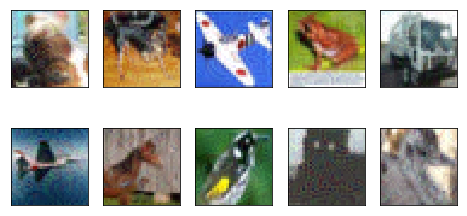


[[ 0.86086494  0.45774978 -0.04080509  0.42361343  0.22738311  0.36224753
   0.41933003  0.54379052  0.54480875  0.7476331 ]
 [ 0.6208269   0.32305709  0.25822848  0.12950258  0.16053845  0.56330878
   0.44187349  0.36415511  0.60530257  1.31449234]]
<NDArray 2x10 @gpu(0)>

[[-0.00081484  0.00033939  0.01105584 -0.01771183  0.04914688 -0.0776163
   0.0074151  -0.00136637 -0.04334011 -0.01749903]
 [ 0.02110897  0.00915922  0.01287662  0.00286914 -0.04126899 -0.0169199
   0.02211018  0.05105556  0.09108437  0.07623332]]
<NDArray 2x10 @gpu(0)>
iter: 100 loss: -33.3837
-33.3837


In [10]:
show_data(data[:10], False)
backgrad_data, (loss,) = generate_backgrad_data(net, data.copy(), label, max_iters=100, lr=0.1, iter_log=True, clip=False)
print loss

## 3.3 other implement

In [10]:
if False:
    data_dict = gluon.ParameterDict()
    data_param = gluon.Parameter('data')
    data_param.set_data(data)
    data_dict.update({'data': data_param})
    data_dict['data'].set_data(data)
    trainer = gluon.Trainer(data_dict, 'sgd', {'learning_rate': 0.1, 'momentum': 0.9, 'wd': 1e-4})
    with autograd.record():
        output = net(data.as_in_context(ctx))
        loss = -loss_f(output, label.as_in_context(ctx))
    print data_dict['data'].data()
    loss.backward()
    #SGD(data, 0.1)
    import mxnet.optimizer as opt
    optimizer = opt.create('sgd', **{'learning_rate': 0.1, 'momentum': 0.9, 'wd': 1e-4})#, param_dict=param_dict)
    updater = opt.get_updater(optimizer)

# 4. define train function

In [7]:
"""
train
"""
import datetime
import utils
import sys
from random import random

num_class = 10

def abs_mean(W):
    return nd.mean(nd.abs(W)).asscalar()

def in_list(e, l):
    for i in l:
        if i == e:
            return True
    else:
        return False

def train(net, train_data, valid_data, num_epochs, lr, lr_period, 
          lr_decay, wd, ctx, w_key, output_file=None, verbose=False, loss_f=gluon.loss.SoftmaxCrossEntropyLoss(), 
          use_mixup=False, mixup_alpha=0.2, back_grad_args=None):
    
    def train_batch(data, label, i, use_backgrad, loss_f, bn_control=None):
        data = data.as_in_context(ctx)
        _label = label.copy()
        label = label.as_in_context(ctx)
        
        # generate backgrad data
        _bloss = None
        if use_backgrad:
            args = back_grad_args
            args['prob'] = args.get('prob', 1)      # prob to use back grad data argument to prove origin data is used.
            if random() <= args['prob']:
                args['max_iters'], args['lr'] = args.get('max_iters', 60), args.get('lr', 0.1)
                _data, (_bloss,) = generate_backgrad_data(args['net'], data.copy(), label, args['max_iters'], args['lr'], 
                                                          iter_log=False, clip=False, bn_control=bn_control)
                if args.has_key('soft_label_th'):
                    label = get_soft_label(label, num_class, args['soft_label_th'])
                    loss_f = args['soft_label_loss_f']
                    
                if args.has_key('show_iters') and i % args['show_iters'] == 0:
                    show_data(data[:5])
                    
                if args.has_key('attach_batch') and args['attach_batch'] == True:
                    data = nd.concat(data, _data, dim=0)
                    label = nd.concat(label, label, dim=0)
                    _label = nd.concat(_label, _label, dim=0)
                else:
                    data = _data
                    
        label = label.as_in_context(ctx)            
        with autograd.record():
            output = net(data.as_in_context(ctx))
            loss = loss_f(output, label)
        loss.backward()
        trainer.step(data.shape[0])

        _loss = nd.mean(loss).asscalar()
#         if not use_mixup and (back_grad_args is None or not args.has_key('soft_label_th')):
#             _acc = utils.accuracy(output, label)
        if not use_mixup:
            _acc = utils.accuracy(output, _label.as_in_context(ctx))
        else:
            _acc = None

        if verbose and i % 100 == 0:
            print " # iter", i,
            print "loss %.5f" % _loss, 
            if not use_mixup: print "acc %.5f" % _acc,
            print "w (",
            for k in w_key:
                w = net.collect_params()[k]
                print "%.5f, " % abs_mean(w.data()),
            print ") g (",
            for k in w_key:
                w = net.collect_params()[k]
                print "%.5f, " % abs_mean(w.grad()),
            print ")"
        return _loss, _acc, _bloss
            
    if output_file is None:
        output_file = sys.stdout
        stdout = sys.stdout
    else:
        output_file = open(output_file, "w")
        stdout = sys.stdout
        sys.stdout = output_file
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr, 'momentum': 0.9, 'wd': wd})
    prev_time = datetime.datetime.now()
    
    if verbose:
        print " #", utils.evaluate_accuracy(valid_data, net, ctx)
    
    bn_control = None
    
    i = 0
    for epoch in range(num_epochs):
        train_loss = 0.
        train_acc = 0.
        bloss, btime = 0., 0
        if in_list(epoch, lr_period):
            trainer.set_learning_rate(trainer.learning_rate * lr_decay)
        
        # back grad
        use_backgrad = False
        if back_grad_args is not None:
            args = back_grad_args
            if args.has_key('take_turn'):
                args['take_turn'] = not args['take_turn'] # only odd epoch(start 0) will use back grad

            if (not args.has_key('take_turn')) or args['take_turn'] == True:
                if not args.has_key('prob'): print "# back grad turn." 
                use_backgrad = True
        
        # mixup
        if not use_mixup:
            for data, label in train_data:
                _loss, _acc, _bloss = train_batch(data, label, i, use_backgrad, loss_f, bn_control)
                train_loss += _loss
                if _acc is not None: train_acc += _acc
                if _bloss is not None: 
                    bloss += _bloss
                    btime += 1
                i += 1
        else:
            for x, y in train_data:
                l = x.shape[0] / 2
                data, label = mixup(x[:l], y[:l], x[l:2*l], y[l:2*l], mixup_alpha, 10)
                _loss, _, _bloss = train_batch(data, label, i, use_backgrad, loss_f)
                train_loss += _loss
                if _bloss is not None: 
                    bloss += _bloss
                    btime += 1
                i += 1
        
        # log info
        cur_time = datetime.datetime.now()
        h, remainder = divmod((cur_time - prev_time).seconds, 3600)
        m, s = divmod(remainder, 60)
        time_str = "Time %02d:%02d:%02d" % (h, m, s)
        
        train_loss /= len(train_data)
        train_acc /= len(train_data)
        if train_acc < 1e-6:
            train_acc = utils.evaluate_accuracy(train_data, net, ctx)
        
        if valid_data is not None:
            valid_acc = utils.evaluate_accuracy(valid_data, net, ctx)
            epoch_str = ("epoch %d, loss %.5f, train_acc %.4f, valid_acc %.4f" 
                         % (epoch, train_loss, train_acc, valid_acc))
        else:
            epoch_str = ("epoch %d, loss %.5f, train_acc %.4f"
                        % (epoch, train_loss, train_acc))
            
        if back_grad_args is not None:
            epoch_str += (", bloss %.5f" % (-bloss / btime))
            if back_grad_args.has_key('use_batch_mean_std'):
                bn_control = BNControl(net.net, use_batch=back_grad_args['use_batch_mean_std'])
            
        prev_time = cur_time
        output_file.write(epoch_str + ", " + time_str + ",lr " + str(trainer.learning_rate) + "\n")
        output_file.flush()  # to disk only when flush or close

    if output_file != stdout:
        sys.stdout = stdout
        output_file.close()

# 5. get net and do EXP

## 5.1 baseline: general lr policy train my resnet18

In [ ]:
num_epochs = 200
batch_size = 128
learning_rate = 0.1
weight_decay = 1e-4
lr_period = [80, 150]
lr_decay=0.1
log_file = None
loss_f = gluon.loss.SoftmaxCrossEntropyLoss()

train_data, valid_data = data_loader(batch_size, transform_train_DA1, num_workers=4)
net = ResNet(10)
net.initialize(ctx=ctx)
net.hybridize()
train(net, train_data, valid_data, num_epochs, learning_rate, lr_period, lr_decay, weight_decay, ctx, 
      [], log_file, False, loss_f)

net.save_params("../../models/resnet18_me_200e")

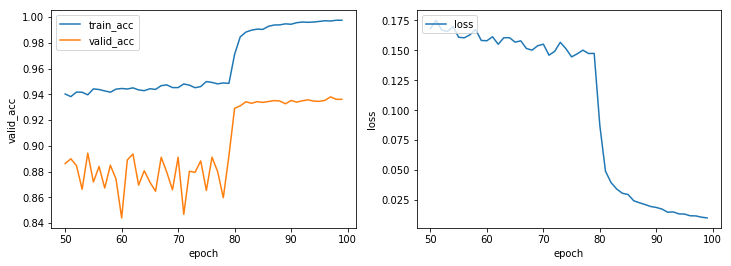

lr [0.1, 0.01, 0.001]


In [13]:
update('../../log/resnet18_me_200e.log', x_range=(50, 100))
# show_log('../../log/resnet18_me_200e.log')

## 5.2 train with backgrad image by online way

In [ ]:
net = ResNet(10)
batch_size = 128
net.initialize(ctx=ctx)
net.hybridize()

num_epochs = 200
learning_rate = 0.1
weight_decay = 1e-4
lr_period = [80, 150]
lr_decay=0.1
log_file = None
loss_f = gluon.loss.SoftmaxCrossEntropyLoss()

train_data, valid_data = data_loader(batch_size, transform_train_DA1, num_workers=2)
train(net, train_data, valid_data, num_epochs, learning_rate, lr_period, lr_decay, weight_decay, ctx, 
      [], log_file, False, loss_f, back_grad_args={'net': net, 'max_iters': 10, 'lr': 0.5, 'prob': 0.5})#, 'show_iters': 1000})
net.save_params("../../models/resnet18_me_backgrad_prob_online_iter10_lr05")

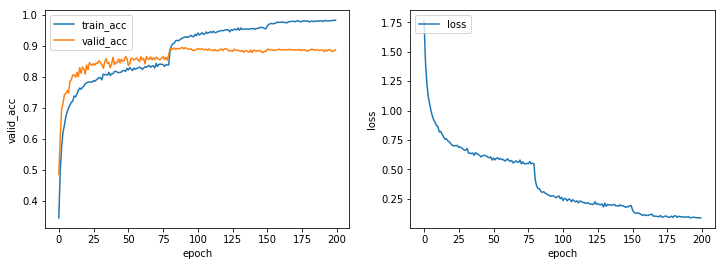

lr [0.1, 0.01, 0.001]


In [11]:
update('../../log/resnet18_me_backgrad_prob_online_iter10_lr05.log', x_range=(0, -1))
# show_log('../../log/resnet18_me_backgrad_prob_online_iter10_lr05.log')

In [ ]:
net = ResNet(10)
batch_size = 128
net.initialize(ctx=ctx)
net.hybridize()

num_epochs = 200
learning_rate = 0.1
weight_decay = 1e-4
lr_period = [80, 150]
lr_decay=0.1
log_file = None
loss_f = gluon.loss.SoftmaxCrossEntropyLoss()

train_data, valid_data = data_loader(batch_size, transform_train_DA1, num_workers=2)
train(net, train_data, valid_data, num_epochs, learning_rate, lr_period, lr_decay, weight_decay, ctx, 
      [], log_file, False, loss_f, back_grad_args={'net': net, 'max_iters': 10, 'lr': 0.1, 'prob': 0.5})#, 'show_iters': 1000})
net.save_params("../../models/resnet18_me_backgrad_prob_online_iter10_lr01")

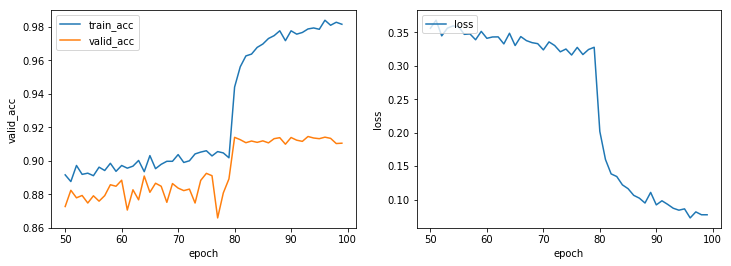

lr [0.1, 0.01, 0.001]


In [12]:
update('../../log/resnet18_me_backgrad_prob_online_iter10_lr01.log', x_range=(50, 100))
# show_log('../../log/resnet18_me_backgrad_prob_online_iter10_lr01.log')

## 5.3 use soft label (0.05, 0.1) online train

In [ ]:
net = ResNet(10)
batch_size = 128
net.initialize(ctx=ctx)
net.hybridize()

num_epochs = 200
learning_rate = 0.1
weight_decay = 1e-4
lr_period = [80, 150]
lr_decay=0.1
log_file = None
loss_f = gluon.loss.SoftmaxCrossEntropyLoss()
soft_label_loss_f = gluon.loss.SoftmaxCrossEntropyLoss(sparse_label=False)

train_data, valid_data = data_loader(batch_size, transform_train_DA1, num_workers=2)
train(net, train_data, valid_data, num_epochs, learning_rate, lr_period, lr_decay, weight_decay, ctx, [], log_file, False, loss_f, 
      back_grad_args={'net': net, 'max_iters': 10, 'lr': 0.1, 'prob': 0.5, 
                      'soft_label_th': 0.05, 'soft_label_loss_f': soft_label_loss_f})#, 'show_iters': 1000})
net.save_params("../../models/resnet18_me_backgrad_prob_online_iter10_lr01_softlabel005")

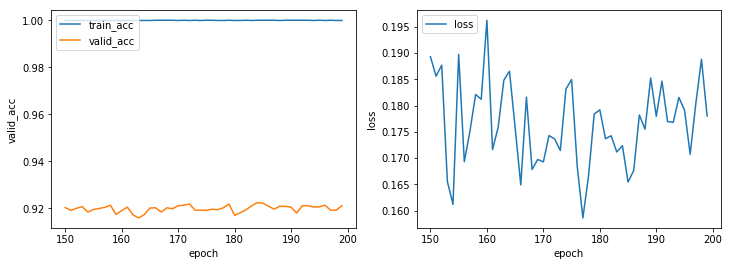

lr [0.1, 0.01, 0.001]


In [9]:
update('../../log/resnet18_me_backgrad_prob_online_iter10_lr01_softlabel005.log', x_range=(150, -1))
# show_log('../../log/resnet18_me_backgrad_prob_online_iter10_lr01_softlabel005.log')

In [ ]:
net = ResNet(10)
batch_size = 128
net.initialize(ctx=ctx)
net.hybridize()

num_epochs = 200
learning_rate = 0.1
weight_decay = 1e-4
lr_period = [80, 150]
lr_decay=0.1
log_file = None
loss_f = gluon.loss.SoftmaxCrossEntropyLoss()
soft_label_loss_f = gluon.loss.SoftmaxCrossEntropyLoss(sparse_label=False)

train_data, valid_data = data_loader(batch_size, transform_train_DA1, num_workers=2)
train(net, train_data, valid_data, num_epochs, learning_rate, lr_period, lr_decay, weight_decay, ctx, [], log_file, False, loss_f, 
      back_grad_args={'net': net, 'max_iters': 10, 'lr': 0.1, 'prob': 0.5, 
                      'soft_label_th': 0.1, 'soft_label_loss_f': soft_label_loss_f})#, 'show_iters': 1000})
net.save_params("../../models/resnet18_me_backgrad_prob_online_iter10_lr01_softlabel01")

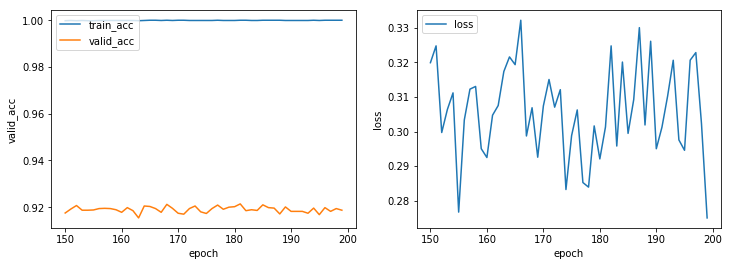

lr [0.1, 0.01, 0.001]


In [10]:
update('../../log/resnet18_me_backgrad_prob_online_iter10_lr01_softlabel01.log', x_range=(150, -1))
# show_log('../../log/resnet18_me_backgrad_prob_online_iter10_lr01_softlabel01.log')

In [ ]:
net = ResNet(10)
batch_size = 64
net.initialize(ctx=ctx)
net.hybridize()

num_epochs = 200
learning_rate = 0.1
weight_decay = 1e-4
lr_period = [80, 150]
lr_decay=0.1
log_file = None
loss_f = gluon.loss.SoftmaxCrossEntropyLoss()
soft_label_loss_f = gluon.loss.SoftmaxCrossEntropyLoss(sparse_label=False)

train_data, valid_data = data_loader(batch_size, transform_train_DA1, num_workers=2)
train(net, train_data, valid_data, num_epochs, learning_rate, lr_period, lr_decay, weight_decay, ctx, [], log_file, False, loss_f, 
      back_grad_args={'net': net, 'max_iters': 10, 'lr': 0.1, 'prob': 0.5, 'attach_batch': True,
                      'soft_label_th': 0.1, 'soft_label_loss_f': soft_label_loss_f})#, 'show_iters': 1000})
net.save_params("../../models/resnet18_me_backgrad_prob_online_iter10_lr01_softlabel01_addbatch")

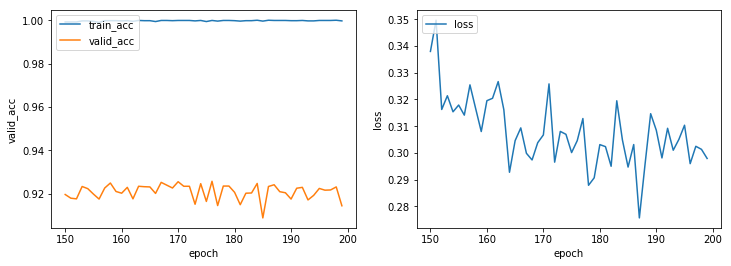

lr [0.1, 0.01, 0.001]


In [11]:
update('../../log/resnet18_me_backgrad_prob_online_iter10_lr01_softlabel01_addbatch.log', x_range=(150, -1))
# show_log('../../log/resnet18_me_backgrad_prob_online_iter10_lr01_softlabel01_addbatch.log')

In [ ]:
net = ResNet(10)
batch_size = 64
net.load_params("../../models/resnet18_me_backgrad_prob_online_iter10_lr01_softlabel01_addbatch", ctx=ctx)
net.hybridize()

num_epochs = 100
learning_rate = 0.001
weight_decay = 1e-4
lr_period = [50, 150]
lr_decay=0.1
log_file = None
loss_f = gluon.loss.SoftmaxCrossEntropyLoss()
soft_label_loss_f = gluon.loss.SoftmaxCrossEntropyLoss(sparse_label=False)

train_data, valid_data = data_loader(batch_size, transform_train_DA1, num_workers=2)
train(net, train_data, valid_data, num_epochs, learning_rate, lr_period, lr_decay, weight_decay, ctx, [], log_file, False, loss_f, 
      back_grad_args={'net': net, 'max_iters': 15, 'lr': 0.1, 'prob': 0.5, 'attach_batch': True,
                      'soft_label_th': 0.1, 'soft_label_loss_f': soft_label_loss_f})#, 'show_iters': 1000})

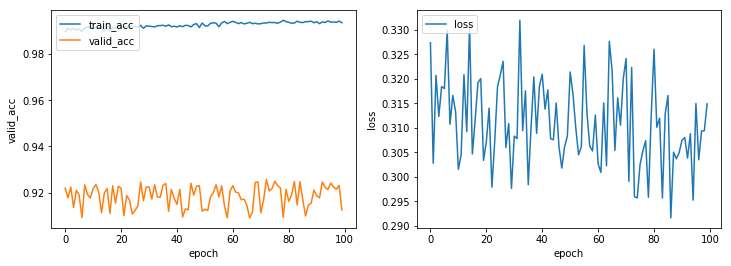

lr [0.001, 0.0001]


In [12]:
update('../../log/resnet18_me_backgrad_prob_online_iter10_lr01_softlabel01_addbatch_200_300e.log')
# show_log('../../log/resnet18_me_backgrad_prob_online_iter10_lr01_softlabel01_addbatch_200_300e.log')

In [ ]:
net = ResNet(10)
batch_size = 64
net.initialize(ctx=ctx)
net.hybridize()

num_epochs = 200
learning_rate = 0.1
weight_decay = 1e-4
lr_period = [80, 150]
lr_decay=0.1
log_file = None
loss_f = gluon.loss.SoftmaxCrossEntropyLoss()
soft_label_loss_f = gluon.loss.SoftmaxCrossEntropyLoss(sparse_label=False)

train_data, valid_data = data_loader(batch_size, transform_train_DA1, num_workers=2)
train(net, train_data, valid_data, num_epochs, learning_rate, lr_period, lr_decay, weight_decay, ctx, [], log_file, False, loss_f, 
      back_grad_args={'net': net, 'max_iters': 10, 'lr': 0.1, 'prob': 1, 'attach_batch': True,
                      'soft_label_th': 0.1, 'soft_label_loss_f': soft_label_loss_f})#, 'show_iters': 1000})
net.save_params("../../models/resnet18_me_backgrad_online_iter10_lr01_softlabel01_addbatch")

## 5.4 add bn_control

In [ ]:
net = ResNet(10)
batch_size = 128
net.initialize(ctx=ctx)
net.hybridize()

num_epochs = 200
learning_rate = 0.1
weight_decay = 1e-4
lr_period = [80, 150]
lr_decay=0.1
log_file = None
loss_f = gluon.loss.SoftmaxCrossEntropyLoss()

train_data, valid_data = data_loader(batch_size, transform_train_DA1, num_workers=2)
train(net, train_data, valid_data, num_epochs, learning_rate, lr_period, lr_decay, weight_decay, ctx, 
      [], log_file, False, loss_f, back_grad_args={'net': net, 'max_iters': 10, 'lr': 0.5, 'prob': 0.5, 
                                                  'use_batch_mean_std': True})#, 'show_iters': 1000})
net.save_params("../../models/resnet18_me_backgrad_prob_online_iter10_lr05_bT")